<a href="https://colab.research.google.com/github/LucFrachon/vae_anomaly_detection/blob/main/anomaly_detection_using_vaes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Anomaly Detection using a Variational Auto-Encoder
In this project, we are using a Variational Auto-Encoder (VAE) to detect anomalies in a timeseries.

## 1. Introduction to VAEs in Anomaly Detection
### 1.1 What is a VAE?
VAEs are a class of generative models that learn a compressed latent representation of the data. Intuitively, they learn the inherent structure of the data, so that it can be reconstructed just by providing a few values. As an analogy, imagine that you were asked to describe any object to someone just from basic shapes, so that they can draw it. It would take ages to explain everything in enough detail. Now, imaging you can tell them the object is in fact a dog. Immediately, it becomes much easier to explain, and within a few minutes, you should be able to give a pretty accurate description of the dog. This is because you and your friend share a common knowledge of what constitutes a dog and what distinguishes one dog from another. With this pre-learned knowledge, the description of the object becomes much more compact. 

To learn this structure, the VAE has two parts: An encoder and a decoder. The compact representation (the "latent vector") is sandwiched between these two parts. During training, we present the encoder with data samples that it converts into latent vectors. Then the decoder takes the latent vectors and tries to reconstruct the data samples. By minimising the recontruction error (plus a regularisation loss, more on that later), the encoder gets better at compressing the data into a meaningful latent vector, and the decoder becomes better at converting this latent vector into plausible reconstructed samples.

However, we also need to make sure that the VAE is able to reconstruct samples outside of the training set, i.e. to generalise. This is achieved by penalising ("regularising") the reconstruction loss with an additional term, the Kullback-Leibler Divergence. In broad terms, this ensures that the VAE learns the distribution of the data, rather than the datapoints themselves. There is much more to the theory of VAEs (e.g. the "reparameterisation trick") but this is outside the scope of this notebook. You can learn a lot more about VAEs [here](https://arxiv.org/abs/1606.05908) \[1\].

### 1.2 Why use a VAE in Anomaly Detection?

The idea behind Anomaly Detection is to detect samples that are far from what is usually seen, in some sense or other. The definition of "far" is the difficult bit. In simple, one-dimensional cases, we could just look at the value tracked over time and decide that extreme values are anomalies. Lots of methods use this idea in more or less sophisticated ways.

However, things become trickier in higher-dimensional spaces where variables interact with each other or are correlated in some non-obvious ways. Sure, a sheep is "far" from a dog, but how do you formalise this distance? Its size is clearly not enough: some dogs are as big or larger than sheeps. Colour doesn't work either -- there are black sheeps and white dogs. Ear shape -- let's not even go there. The decision will clearly require a combination of many variables.

This is where VAEs come in useful. As we saw, a VAE trained on dogs will have learned a latent, non-explicit representation of the structural features of a dog. What will happen if we pass it an instance of a sheep? It will try to reconstruct the sheep, but since the structure of a sheep is different to that of a dog, most likely the reconstruction will not be very good. As a result, the reconstruction loss will probably be quite poor on this particular sample, much worse than on dog instances -- at least if our VAE has benn properly trained. By detecting data samples that cause a large reconstruction loss, we can therefore hope to identify anomalies.

The process is as follows:  

- Gather and preprocess data, including train/test split,
- Build a VAE and train it on the training set,
- Pass test samples to the VAE and record the reconstruction loss for each,
- Identify test samples with a reconstruction loss higher than some criterion and flag them as anomalies.

### 1.3 Scope of this project
In this notebook, we will use one of the public datasets available on Kaggle: https://www.kaggle.com/boltzmannbrain/nab
It contains many one-dimensional timeseries, but to make things a bit more interesting, we will do some feature engineering and make the data multi-dimensional. This is also often useful in improving the accuracy of any model.

## 2. Data preprocessing

Much of the pre-processing in this section has been inspired by this great [notebook](https://www.kaggle.com/victorambonati/unsupervised-anomaly-detection) by Victor Ambonati.

Before we start, we need to install and import some useful libraries. For this project, I am using [Pytorch-Lightning](https://pytorch-lightning.readthedocs.io/en/latest/), a thin layer on top of Pytorch that handles a lot of the tedious tasks such as writing a training loop. The experiments are recorded using [Weights and Biases](https://app.wandb.ai/), but you can use whatever method you want, or none.

In [ ]:
!pip install lightning wandb kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!touch ~/.kaggle/kaggle.json

api_token = {"username":"xxxx","key":"xxxx"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
import os, sys
from argparse import Namespace
import numpy as np
import pandas as pd
from pathlib import Path
from collections import OrderedDict
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import sklearn
from sklearn import preprocessing
import matplotlib
import matplotlib.pyplot as plt
import pytorch_lightning as pl
# from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.loggers.wandb import WandbLogger  # newer implementation
import wandb
import kaggle

plt.style.use('tableau-colorblind10')

In [ ]:
print('Python version:', sys.version)
print('Package versions:')
print('Pytorch:', torch.__version__)
print('Pytorch-Lightning:', pl.__version__)
print('Matplotlib:', matplotlib.__version__)
print('scikit-learn:', sklearn.__version__)
print('Weights&Biases:', wandb.__version__)

Python version: 3.9.16 (main, Dec  7 2022, 01:11:51) 
[GCC 9.4.0]
Package versions:
Pytorch: 2.0.0+cu118
Pytorch-Lightning: 2.0.1
Matplotlib: 3.7.1
scikit-learn: 1.2.2
Weights&Biases: 0.14.2


In [ ]:
!mkdir /content/raw_data
!kaggle datasets download -d boltzmannbrain/nab 

100% 1.64M/1.64M [00:01<00:00, 1.84MB/s]
100% 1.64M/1.64M [00:01<00:00, 1.65MB/s]


In [ ]:
!unzip /content/nab.zip -d /content/raw_data

Archive:  /content/nab.zip
  inflating: /content/raw_data/README.md  
  inflating: /content/raw_data/artificialNoAnomaly/artificialNoAnomaly/art_daily_no_noise.csv  
  inflating: /content/raw_data/artificialNoAnomaly/artificialNoAnomaly/art_daily_perfect_square_wave.csv  
  inflating: /content/raw_data/artificialNoAnomaly/artificialNoAnomaly/art_daily_small_noise.csv  
  inflating: /content/raw_data/artificialNoAnomaly/artificialNoAnomaly/art_flatline.csv  
  inflating: /content/raw_data/artificialNoAnomaly/artificialNoAnomaly/art_noisy.csv  
  inflating: /content/raw_data/artificialWithAnomaly/artificialWithAnomaly/art_daily_flatmiddle.csv  
  inflating: /content/raw_data/artificialWithAnomaly/artificialWithAnomaly/art_daily_jumpsdown.csv  
  inflating: /content/raw_data/artificialWithAnomaly/artificialWithAnomaly/art_daily_jumpsup.csv  
  inflating: /content/raw_data/artificialWithAnomaly/artificialWithAnomaly/art_daily_nojump.csv  
  inflating: /content/raw_data/artificialWithAnomal

These are the available datasets:

In [ ]:
for dirname, _, filenames in os.walk('/content/raw_data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/raw_data/README.md
/content/raw_data/realTraffic/realTraffic/speed_t4013.csv
/content/raw_data/realTraffic/realTraffic/speed_6005.csv
/content/raw_data/realTraffic/realTraffic/speed_7578.csv
/content/raw_data/realTraffic/realTraffic/occupancy_6005.csv
/content/raw_data/realTraffic/realTraffic/occupancy_t4013.csv
/content/raw_data/realTraffic/realTraffic/TravelTime_387.csv
/content/raw_data/realTraffic/realTraffic/TravelTime_451.csv
/content/raw_data/realTraffic/realTraffic/.DS_Store
/content/raw_data/realTraffic/__MACOSX/realTraffic/._speed_6005.csv
/content/raw_data/realTraffic/__MACOSX/realTraffic/._occupancy_6005.csv
/content/raw_data/realTraffic/__MACOSX/realTraffic/._.DS_Store
/content/raw_data/realKnownCause/realKnownCause/rogue_agent_key_updown.csv
/content/raw_data/realKnownCause/realKnownCause/machine_temperature_system_failure.csv
/content/raw_data/realKnownCause/realKnownCause/cpu_utilization_asg_misconfiguration.csv
/content/raw_data/realKnownCause/realKnownCause/e

We pick `machine_temperature_system_failure.csv`, but the pipeline below can apply to others too, with some minor adaptation. This data comes from a temperature sensor from an internal component of a large industrial machine.

In [ ]:
!mkdir /content/datasets
datafile_path = Path('/content/raw_data/realKnownCause/realKnownCause/machine_temperature_system_failure.csv')
datasets_dir = Path('/content/datasets/')
log_path = Path('/content/logs')

The data is monodimensional: It only has one "predictor" (`timestamp`) and the outcome (`value`):

In [ ]:
raw_dt = pd.read_csv(datafile_path)
raw_dt.head()

,timestamp,value
0,2013-12-02 21:15:00,73.967322
1,2013-12-02 21:20:00,74.935882
2,2013-12-02 21:25:00,76.124162
3,2013-12-02 21:30:00,78.140707
4,2013-12-02 21:35:00,79.329836


In [ ]:
raw_dt.describe()

,value
count,22695.000000
mean,85.926498
std,13.746912
min,2.084721
25%,83.080078
50%,89.408246
75%,94.016252
max,108.510543


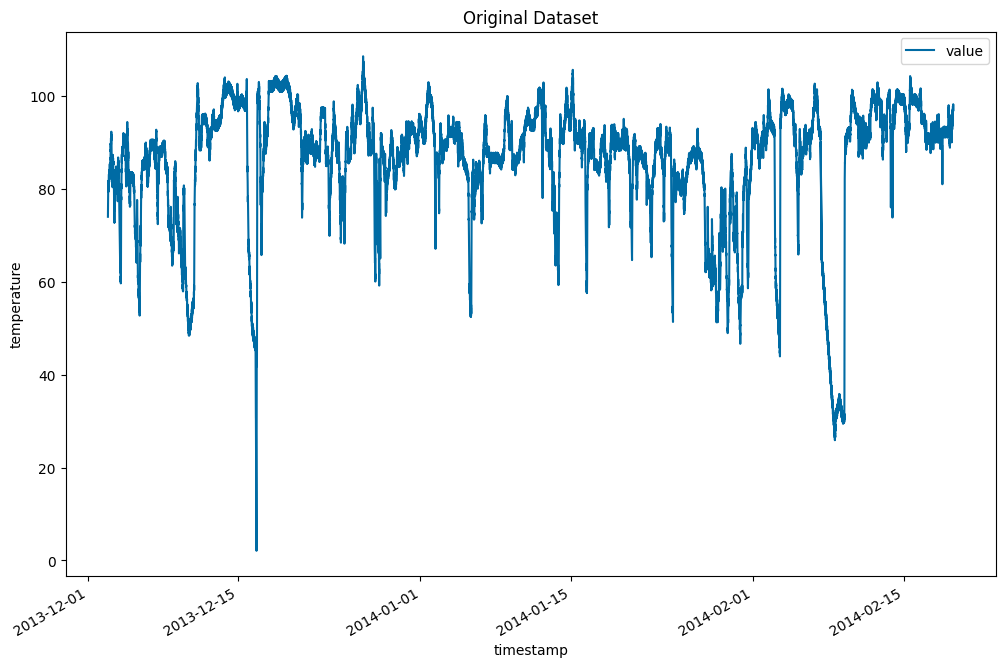

In [ ]:
data = raw_dt.copy()
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.plot(x='timestamp', y='value', figsize=(12, 8))
plt.ylabel("temperature")
plt.title("Original Dataset");

We can already intuitively see a few of unusual values. We will see if our model will be able to pick them up... For reference, the paper that introduced this dataset can be found [here](https://reader.elsevier.com/reader/sd/pii/S0925231217309864?token=C53EC725CFFDDB81C89A60CA5CA9B4DDD0E1DBFC0F8975119E6CB3555C8B2D6AC0418BF5AE7AE721DA3BB77DDD638190) \[1\] and its figure 1 shows this timeseries with hand-labeled anomalies. The first anomaly, around Dec 16th, is a planned shutdown. The third anomaly, around Feb 8th, is a catastrophic failure. Around Jan 30th, a harder-to-detect anomaly indicated the onset of the problem that led to anomaly 3.

In [ ]:
data['timestamp'].min(), data['timestamp'].max()

(Timestamp('2013-12-02 21:15:00'), Timestamp('2014-02-19 15:25:00'))

We do not have much information about what kind of machine or industry we are dealing with, which is a bit of an issue when trying to use this data, especially when it comes to feature engineering. We will therefore have to make assumptions. 

The timestamps cover the Christmas and New Year holidays. Since we are dealing with an industrial machine, it stands to reason that its workload might be affected by holidays, and maybe even by the proximity (in time) of a holiday. In the absence of additional information, we are going to assume that the applicable holidays are those typical in Europe and the Americas, i.e. Christmas and New Year's Day. By the same reasoning, we might need to know the day of the week (possibly lower workload on weekends?) or the hour of the day. Again, we will assume that weekends are Satuday and Sunday. 

We can easily extract all this information from the timestamp.

In [ ]:
data['day'] = data['timestamp'].dt.day
data['month'] = data['timestamp'].dt.month
data['hour_min'] = data['timestamp'].dt.hour + data['timestamp'].dt.minute / 60

data['day_of_week'] = data['timestamp'].dt.dayofweek
data['holiday'] = 0
data.loc[(data['day'] == 25) & (data['month'] == 12),'holiday'] = 1  # Christmas
data.loc[(data['day'] == 1) & (data['month'] == 1),'holiday'] = 1  # New Year's Day

(Later, we will actually drop `day` and `month` -- we will get back to that).

In [ ]:
holidays = data.loc[data['holiday'] == 1, 'timestamp'].dt.date.unique()
holidays

array([datetime.date(2013, 12, 25), datetime.date(2014, 1, 1)],
      dtype=object)

We add two temporary columns to compute the distance in days to or from each holiday.

In [ ]:
for i, hd in enumerate(holidays):
    data['hol_' + str(i)] = data['timestamp'].dt.date - hd

We are interested by the proximity to or from any holiday, so we want only the shortest gap:

In [ ]:
for i in range(data.shape[0]):
    if np.abs(data.loc[data.index[i], 'hol_0']) <= np.abs(data.loc[data.index[i], 'hol_1']):
        data.loc[data.index[i], 'gap_holiday'] = data.loc[data.index[i], 'hol_0']
    else:
        data.loc[data.index[i], 'gap_holiday'] = data.loc[data.index[i], 'hol_1']

In [ ]:
data['gap_holiday'] = data['gap_holiday'].astype('timedelta64[D]')

We no longer need the temporary columns:

In [ ]:
data.drop(['hol_0', 'hol_1'], axis=1, inplace=True)

Finally, we convert the timestamp into something easier to plot.

In [ ]:
data['t'] = (data['timestamp'].astype(np.int64)/1e11).astype(np.int64)
data.drop('timestamp', axis=1, inplace=True)
data

,value,day,month,hour_min,day_of_week,holiday,gap_holiday,t
0,73.967322,2,12,21.250000,0,0,-23.0,13860189
1,74.935882,2,12,21.333333,0,0,-23.0,13860192
2,76.124162,2,12,21.416667,0,0,-23.0,13860195
3,78.140707,2,12,21.500000,0,0,-23.0,13860198
4,79.329836,2,12,21.583333,0,0,-23.0,13860201
...,...,...,...,...,...,...,...,...
22690,98.185415,19,2,15.083333,2,0,49.0,13928223
22691,97.804168,19,2,15.166667,2,0,49.0,13928226
22692,97.135468,19,2,15.250000,2,0,49.0,13928229
22693,98.056852,19,2,15.333333,2,0,49.0,13928232


In [ ]:
cont_vars = ['value', 'hour_min', 'gap_holiday', 't']
cat_vars = ['day', 'month', 'day_of_week', 'holiday']

We now apply a Label Encoder to encode the categorical data from 0 to n, with n being the number of classes for the variable.

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoders = [LabelEncoder() for _ in cat_vars] 
for col, enc in zip(cat_vars, label_encoders):
    data[col] = enc.fit_transform(data[col])
    
data

,value,day,month,hour_min,day_of_week,holiday,gap_holiday,t
0,73.967322,1,2,21.250000,0,0,-23.0,13860189
1,74.935882,1,2,21.333333,0,0,-23.0,13860192
2,76.124162,1,2,21.416667,0,0,-23.0,13860195
3,78.140707,1,2,21.500000,0,0,-23.0,13860198
4,79.329836,1,2,21.583333,0,0,-23.0,13860201
...,...,...,...,...,...,...,...,...
22690,98.185415,18,1,15.083333,2,0,49.0,13928223
22691,97.804168,18,1,15.166667,2,0,49.0,13928226
22692,97.135468,18,1,15.250000,2,0,49.0,13928229
22693,98.056852,18,1,15.333333,2,0,49.0,13928232


Notice that some of our data are continuous (or 'close to' continuous): `value`, `hour_min`, `gap_holiday` (even though this one only has a resolution of 1 day), `t`. Other variables are categorical: `day`, `month`, `day_week`, `holiday`. In a neural network model, these two types of data need to be handled differently, as we will see later.

It is time to split our data into a train set and a test set. Let's set 30% of the data aside. Since this is a time series, we take the last 30% of the observations (in chronological order) as our test set.

In [ ]:
test_ratio = 0.3

In [ ]:
tr_data = data.iloc[: int(len(data) * (1 - test_ratio))]
tst_data = data.iloc[int(len(data) * (1 - test_ratio)) :]

As we are using a neural network model, the continuous variables need to be normalised. This is important because the weights of a neural network are initialised at random from a common distribution, so all tend to have similar scales initially. Variables whose values spread are across different orders of magnitude would therefore cause serious difficulties when it comes to learning the optimal weights.

In [ ]:
scaler = preprocessing.StandardScaler().fit(tr_data[cont_vars])

In [ ]:
tr_data_scaled = tr_data.copy()
tr_data_scaled[cont_vars] = scaler.transform(tr_data[cont_vars])
tst_data_scaled = tst_data.copy()
tst_data_scaled[cont_vars] = scaler.transform(tst_data[cont_vars])

Note that the test data is normalised using parameters observed on the train set. Otherwise, we would be cheating!

We also need to make sure that there are no values of categorical variables that are present in the test set and not in the training set. But obviously, if we split the data choronologically, there is a strong risk that this happens with the variables `day` and `month`. There are ways to address that through further feature engineering, but here we will simply ignore these two features when we call the dataset in the model definition (see later).

In [ ]:
tr_data_scaled

,value,day,month,hour_min,day_of_week,holiday,gap_holiday,t
0,-1.224398,1,2,1.336685,0,0,-1.866199,-1.732808
1,-1.134136,1,2,1.348691,0,0,-1.866199,-1.732590
2,-1.023399,1,2,1.360698,0,0,-1.866199,-1.732372
3,-0.835474,1,2,1.372704,0,0,-1.866199,-1.732153
4,-0.724658,1,2,1.384711,0,0,-1.866199,-1.731935
...,...,...,...,...,...,...,...,...
15881,0.127174,25,0,1.684873,6,0,1.825637,1.731208
15882,0.120220,25,0,1.696879,6,0,1.825637,1.731426
15883,0.140016,25,0,1.708885,6,0,1.825637,1.731644
15884,0.060621,25,0,1.720892,6,0,1.825637,1.731863


As you can see, the continuous variables are now standardised, while the categorical variables are unchanged. We can now save our data as CSV files and we are ready for the next phase.

In [ ]:
tr_data_scaled.to_csv(datasets_dir/'train.csv', index=False)
tst_data_scaled.to_csv(datasets_dir/'test.csv', index=False)

## 3. VAE Model
We first define a `Dataset` class that takes data from either the train set or the test set. It is also able to filter out some of the columns.

**Note**: For VAE training, we want to use the column `value` as a feature rather than a label, because we are doing unsupervised learning. In that case, we set the argument `lbl_as_feat` to True. If we were training a supervised model, then we would be able to use the same `Dataset` class but we would need to set `lbl_as_feat` to False, and the dataset would return `value` as a label.

In [ ]:
class TSDataset(Dataset):
    def __init__(self, split, cont_vars=None, cat_vars=None, lbl_as_feat=True):
        """
        split: 'train' if we want to get data from the training examples, 'test' for
        test examples, or 'both' to merge the training and test sets and return samples
        from either.
        cont_vars: List of continuous variables to return as features. If None, returns
        all continuous variables available.
        cat_vars: Same as above, but for categorical variables.
        lbl_as_feat: Set to True when training a VAE -- the labels (temperature values)
        will be included as another dimension of the data. Set to False when training
        a model to predict temperatures.
        """
        super().__init__()
        assert split in ['train', 'test', 'both']
        self.lbl_as_feat = lbl_as_feat
        if split == 'train':
            self.df = pd.read_csv(datasets_dir/'train.csv')
        elif split == 'test':
            self.df = pd.read_csv(datasets_dir/'test.csv')
        else:
            df1 = pd.read_csv(datasets_dir/'train.csv')
            df2 = pd.read_csv(datasets_dir/'test.csv')
            self.df = pd.concat((df1, df2), ignore_index=True)
        
        # Select continuous variables to use
        if cont_vars:
            self.cont_vars = cont_vars
            # If we want to use 'value' as a feature, ensure it is returned
            if self.lbl_as_feat:
                try:
                    assert 'value' in self.cont_vars
                except AssertionError:
                    self.cont_vars.insert(0, 'value')
            # If not, ensure it not returned as a feature
            else:
                try:
                    assert 'value' not in self.cont_vars
                except AssertionError:
                    self.cont_vars.remove('value')
                    
        else:  # if no list provided, use all available
            self.cont_vars = ['value', 'hour_min', 'gap_holiday', 't']
        
        # Select categorical variables to use
        if cat_vars:
            self.cat_vars = cat_vars
        else:  # if no list provided, use all available
            self.cat_vars = ['day', 'month', 'day_of_week', 'holiday']
        
        # Finally, make two Numpy arrays for continuous and categorical
        # variables, respectively:
        if self.lbl_as_feat:
            self.cont = self.df[self.cont_vars].copy().to_numpy(dtype=np.float32)
        else:
            self.cont = self.df[self.cont_vars].copy().to_numpy(dtype=np.float32)
            self.lbl = self.df['value'].copy().to_numpy(dtype=np.float32)
        self.cat = self.df[self.cat_vars].copy().to_numpy(dtype=np.int64)
            
    def __getitem__(self, idx):
        if self.lbl_as_feat:  # for VAE training
            return torch.tensor(self.cont[idx]), torch.tensor(self.cat[idx])
        else:  # for supervised prediction
            return torch.tensor(self.cont[idx]), torch.tensor(self.cat[idx]), torch.tensor(self.lbl[idx])
    
    def __len__(self):
        return self.df.shape[0]

Let's try to call from our dataset:

In [ ]:
ds = TSDataset(split='both', cont_vars=['value', 't'], cat_vars=['day_of_week', 'holiday'], lbl_as_feat=True)
print(len(ds))
it = iter(ds)
for _ in range(10):
    print(next(it))

NameError: ignored

As expected, with `lbl_as_feat==True`, we get two arrays for each sample: An array of continuous values represented by floats, and an array of categorical values represented by integers.

Now we move on to the fun part: The model itself. First, define individual modules. The core of our neural network will be a sequence of fully connected layers, whose number and sizes are passed through the hyperparameter `layer_dims` (a list of integers). In our experiment, we used `64,128,256,128,64`, i.e. 5 layers of dimensions 64, 128, 256, 128 and 64. Each layer can be batch-normalised. The input into the first layer is an aggregation of the continuous variables and embedding vectors encoding the categorical variables. 

Embedding vectors are a notion that is heavily used in Natural Language Processing. They are learnable vectors (of dimension 16 in our experiments) that express some non-explicit features of the variables. For instance, the vector for `day_of_week` can take 7 different sets of values (one for each day), each 16-dimensional. Depending on the value of this variable for each sample, the corresponding vector is retrieved in a lookup table, passed to the network, and updated during backpropagation. The vector for `day_of_week==0` could eventually capture the fact that the machine's activity is lower on such days, for instance. The important thing is that this learning is done without our intervention, and there is no easy way to interpret the learned embeddings.

In [ ]:
class Layer(nn.Module):
    '''
    A single fully connected layer with optional batch normalisation and activation.
    '''
    def __init__(self, in_dim, out_dim, bn = True):
        super().__init__()
        layers = [nn.Linear(in_dim, out_dim)]
        if bn: layers.append(nn.BatchNorm1d(out_dim))
        layers.append(nn.LeakyReLU(0.1, inplace=True))
        self.block = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.block(x)

    
class Encoder(nn.Module):
    '''
    The encoder part of our VAE. Takes a data sample and returns the mean and the log-variance of the 
    latent vector's distribution.
    '''
    def __init__(self, **hparams):
        super().__init__()
        self.hparams = Namespace(**hparams)
        self.embeds = nn.ModuleList([
            nn.Embedding(n_cats, emb_size) for (n_cats, emb_size) in self.hparams.embedding_sizes
        ])
        # The input to the first layer is the concatenation of all embedding vectors and continuous
        # values
        in_dim = sum(emb.embedding_dim for emb in self.embeds) + len(self.hparams.cont_vars)
        layer_dims = [in_dim] + [int(s) for s in self.hparams.layer_sizes.split(',')]
        bn = self.hparams.batch_norm
        self.layers = nn.Sequential(
            *[Layer(layer_dims[i], layer_dims[i + 1], bn) for i in range(len(layer_dims) - 1)],
        )
        self.mu = nn.Linear(layer_dims[-1], self.hparams.latent_dim)
        self.logvar = nn.Linear(layer_dims[-1], self.hparams.latent_dim)
    
    def forward(self, x_cont, x_cat):
        x_embed = [e(x_cat[:, i]) for i, e in enumerate(self.embeds)]        
        x_embed = torch.cat(x_embed, dim=1)
        x = torch.cat((x_embed, x_cont), dim=1)
        h = self.layers(x)
        mu_ = self.mu(h)
        logvar_ = self.logvar(h)
        return mu_, logvar_, x  # we return the concatenated input vector for use in loss fn
    

class Decoder(nn.Module):
    '''
    The decoder part of our VAE. Takes a latent vector (sampled from the distribution learned by the 
    encoder) and converts it back to a reconstructed data sample.
    '''
    def __init__(self, **hparams):
        super().__init__()
        self.hparams = Namespace(**hparams)
        hidden_dims = [self.hparams.latent_dim] + [int(s) for s in reversed(self.hparams.layer_sizes.split(','))]
        out_dim = sum(emb_size for _, emb_size in self.hparams.embedding_sizes) + len(self.hparams.cont_vars)
        bn = self.hparams.batch_norm
        self.layers = nn.Sequential(
            *[Layer(hidden_dims[i], hidden_dims[i + 1], bn) for i in range(len(hidden_dims) - 1)],
        )
        self.reconstructed = nn.Linear(hidden_dims[-1], out_dim)
        
    def forward(self, z):
        h = self.layers(z)
        recon = self.reconstructed(h)
        return recon

Now for the full VAE, defined as a LightningModule:

In [ ]:
class VAE(pl.LightningModule):
    def __init__(self, **hparams):
        super().__init__()
        self.save_hyperparameters()
        self.encoder = Encoder(**hparams)
        self.decoder = Decoder(**hparams)
        
    def reparameterize(self, mu, logvar):
        '''
        The reparameterisation trick allows us to backpropagate through the encoder.
        '''
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std) * self.hparams.stdev
            return eps * std + mu
        else:
            return mu
        
    def forward(self, batch):
        x_cont, x_cat = batch
        assert x_cat.dtype == torch.int64
        mu, logvar, x = self.encoder(x_cont, x_cat)
        z = self.reparameterize(mu, logvar)
        recon = self.decoder(z)
        return recon, mu, logvar, x
        
    def loss_function(self, obs, recon, mu, logvar):
        recon_loss = F.smooth_l1_loss(recon, obs, reduction='mean')
        kld = -0.5 * torch.mean(1 + logvar - mu ** 2 - logvar.exp())
        return recon_loss, kld
                               
    def training_step(self, batch, batch_idx):
        recon, mu, logvar, x = self.forward(batch)
        # The loss function compares the concatenated input vector including
        # embeddings to the reconstructed vector
        recon_loss, kld = self.loss_function(x, recon, mu, logvar)
        loss = recon_loss + self.hparams.kld_beta * kld

        self.log('total_loss', loss, on_step=True, prog_bar=True, 
                 logger=True)
        self.log('recon_loss', recon_loss, on_step=True, prog_bar=True, 
                 logger=True)
        self.log('kld', kld, on_step=True, prog_bar=True, logger=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        recon, mu, logvar, x = self.forward(batch)
        recon_loss, kld = self.loss_function(x, recon, mu, logvar)
        loss = recon_loss + self.hparams.kld_beta * kld
        self.log('test_loss', loss)
        return loss
        
    def configure_optimizers(self):
        opt = torch.optim.AdamW(self.parameters(), lr=self.hparams.lr, 
                                weight_decay=self.hparams.weight_decay, 
                                eps=1e-4)
        sch = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            opt, T_0=25, T_mult=1, eta_min=1e-9, last_epoch=-1)
        return [opt], [sch]
    
    def train_dataloader(self):
        dataset = TSDataset('train', cont_vars=self.hparams.cont_vars, 
            cat_vars = self.hparams.cat_vars, lbl_as_feat=True
        )
        return DataLoader(dataset, batch_size=self.hparams.batch_size, num_workers=2, 
            pin_memory=True, persistent_workers=True, shuffle=True
        )
    
    def test_dataloader(self):
        dataset = TSDataset('test', cont_vars=self.hparams.cont_vars,
            cat_vars=self.hparams.cat_vars, lbl_as_feat=True
        )
        return DataLoader(dataset, batch_size=self.hparams.batch_size, num_workers=2, 
            pin_memory=True, persistent_workers=True
        )        

Note that different reconstruction loss functions are possible, the most obvious being the Mean Square Error (MSE). However, it is quite sensitive to outliers. In our case, almost by definition, we expect outliers to be present so it might be useful to use a loss function that is less sensitive to them. We use the Huber loss with $\delta=1$ (called `smooth_l1_loss` in Pytorch).

Let's define the model and data hyperparameters. Note that `stdev` (the standard deviation of the normal distribution from which we sample $\epsilon$ in the `reparameterize()` method) would typically be 1. However, several papers found improvements with smaller values, such as 1e-1. This is what we are going to use, as it gives us lower loss values.

Another hyperparameter worth mentioning is `kld_beta`, the coefficient applied to the KLD loss term in the total loss computation (this hyperparameter means that our VAE is technically a $\beta$-VAE). This helps because the reconstruction loss is typically harder to improve than the KLD loss, therefore if both were weighted equally, the model would start by optimising the KLD loss before improving the reconstruction loss substantially. By setting this coefficient to a value < 1, we try to make sure that both loss values improve at a similar rate.

In [ ]:
cont_features = ['value', 'hour_min', 'gap_holiday', 't'] 
cat_features = ['day_of_week', 'holiday']  # Remember that we removed `day` and `month`

embed_cats = [len(tr_data_scaled[c].unique()) for c in cat_features]

hparams = OrderedDict(
    run='embsz16_latsz16_bsz128_lay64-128-256-128-64_ep100_cosineWR_v1',
    cont_vars = cont_features,
    cat_vars = cat_features,
    embedding_sizes = [(embed_cats[i], 16) for i in range(len(embed_cats))],
    latent_dim = 16,
    layer_sizes = '64,128,256,128,64',
    batch_norm = True,
    stdev = 0.1,
    kld_beta = 0.05,
    lr = 0.001,
    weight_decay = 1e-5,
    batch_size = 128,
    epochs = 60,
)

In [ ]:
hparams

OrderedDict([('run',
              'embsz16_latsz16_bsz128_lay64-128-256-128-64_ep100_cosineWR_v1'),
             ('cont_vars', ['value', 'hour_min', 'gap_holiday', 't']),
             ('cat_vars', ['day_of_week', 'holiday']),
             ('embedding_sizes', [(7, 16), (2, 16)]),
             ('latent_dim', 16),
             ('layer_sizes', '64,128,256,128,64'),
             ('batch_norm', True),
             ('stdev', 0.1),
             ('kld_beta', 0.05),
             ('lr', 0.001),
             ('weight_decay', 1e-05),
             ('batch_size', 128),
             ('epochs', 60)])

In [ ]:
model = VAE(**hparams)
logger = WandbLogger(name=hparams['run'], project='VAE_Anomaly', version=hparams['run'],
     save_dir=log_path
)
ckpt_callback = pl.callbacks.ModelCheckpoint(dirpath='.', filename='vae_weights')
# Replace argument logger by None if you don't have a WandB account (and don't want to create one)
trainer = pl.Trainer(accelerator='gpu', devices=1, logger=logger, 
                     # strategy='dp',  # changed in recent updates, not used in single-GPU anyway
                     # auto_lr_find=False,  # removed in recent updates
                     max_epochs=hparams['epochs'], benchmark=True,
                     callbacks=[ckpt_callback], gradient_clip_val=10., enable_model_summary=True,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 88.4 K
1 | decoder | Decoder | 87.2 K
------------------------------------
175 K     Trainable params
0         Non-trainable params
175 K     Total params
0.702     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=60` reached.


Training takes only a few minutes on GPU. Let's see how this model performs on the test set:

In [ ]:
trainer.test(model)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   0.030552837997674942    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.030552837997674942}]

Hopefully, we should find a test loss that is fairly close to the training loss, indicating that we are not overfitting. A good way to regularise training would be creating a separate validation set and stopping the training early when the loss computed on that set starts to increase (or stops decreasing). Pytorch-Lightning makes early stopping extremely easy to implement: once you have created the validation set, it is just a case of passing an additional argument to the Trainer class. Note also that we could probably improve on these results by further optimising hyperparameters (WandB actually offers an easy framework for running hyperparameter optimisation by random, grid or Bayesian search). For now, let's go with these weights and see if the model can find outliers.

In [ ]:
dataset = TSDataset('test', cont_vars=hparams['cont_vars'],
                    cat_vars=['day_of_week', 'holiday'],
                    lbl_as_feat=True) 

In [ ]:
trained_model = VAE.load_from_checkpoint('./vae_weights-v1.ckpt')
trained_model.freeze()

losses = []
# run predictions for the test set examples
for i in range(len(dataset)):
    x_cont, x_cat = dataset[i]
    x_cont.unsqueeze_(0)
    x_cat.unsqueeze_(0)
    recon, mu, logvar, x = trained_model.forward((x_cont, x_cat))
    recon_loss, kld = trained_model.loss_function(x, recon, mu, logvar)
    losses.append(recon_loss + trained_model.hparams.kld_beta * kld)

data_with_losses = dataset.df
data_with_losses['loss'] = np.asarray(losses)
data_with_losses.sort_values('t', inplace=True)
data_with_losses.head()

,value,day,month,hour_min,day_of_week,holiday,gap_holiday,t,loss
0,0.128276,26,0,-1.712961,0,0,1.90255,1.732299,0.007008
1,-0.038872,26,0,-1.700954,0,0,1.90255,1.732517,0.007454
2,0.088313,26,0,-1.688948,0,0,1.90255,1.732736,0.006989
3,0.124557,26,0,-1.676941,0,0,1.90255,1.732954,0.006872
4,0.014094,26,0,-1.664935,0,0,1.90255,1.733172,0.007123


How are loss values distributed?

In [ ]:
mean, sigma = data_with_losses['loss'].mean(), data_with_losses['loss'].std()
mean, sigma

(0.030552838, 0.01997272)

Let's define a threshold value beyond which instances are classified as anomalies. Here, we set it based on its quantile in the loss distribution. We choose a very high quantile to make sure we are only getting the trail of that distribution:

In [ ]:
quant = 0.999
thresh = data_with_losses['loss'].quantile(quant)  # threshold for anomaly (quantile).
thresh

0.0961497806906702

We can now flag as anomalies any instance where the loss is very far from the centre of the distribution:

In [ ]:
data_with_losses['anomaly'] = data_with_losses['loss'] > thresh
print(data_with_losses.head())

      value  day  month  hour_min  day_of_week  holiday  gap_holiday  \
0  0.128276   26      0 -1.712961            0        0      1.90255   
1 -0.038872   26      0 -1.700954            0        0      1.90255   
2  0.088313   26      0 -1.688948            0        0      1.90255   
3  0.124557   26      0 -1.676941            0        0      1.90255   
4  0.014094   26      0 -1.664935            0        0      1.90255   

          t      loss  anomaly  
0  1.732299  0.007008    False  
1  1.732517  0.007454    False  
2  1.732736  0.006989    False  
3  1.732954  0.006872    False  
4  1.733172  0.007123    False  


Let's see this in a histogram. The orange colour denotes anomalies.

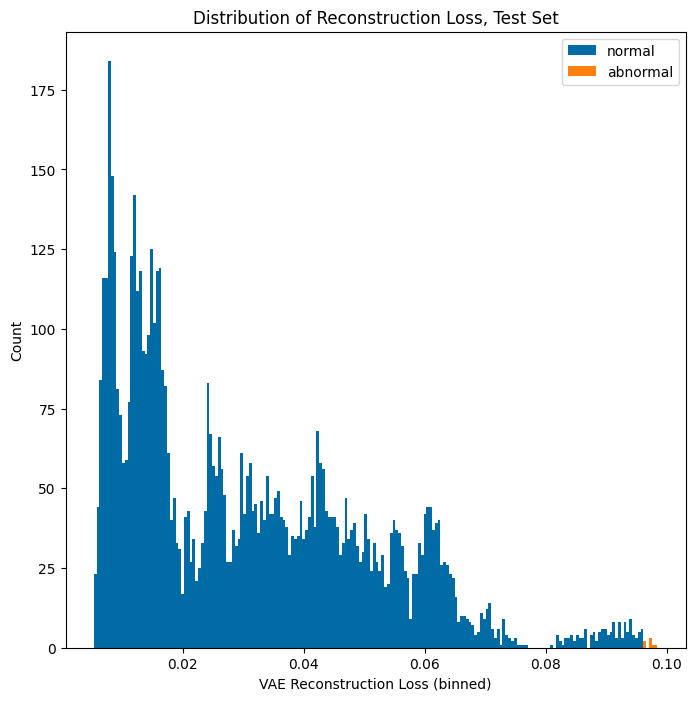

In [ ]:
plt.figure(figsize=(8, 8))
anomalies_loss = data_with_losses.loc[data_with_losses['anomaly'], 'loss']
normals_loss   = data_with_losses.loc[~data_with_losses['anomaly'], 'loss']
plt.hist([normals_loss, anomalies_loss], bins=200, stacked=True, label=['normal', 'abnormal'])
plt.title("Distribution of Reconstruction Loss, Test Set")
plt.xlabel("VAE Reconstruction Loss (binned)")
plt.ylabel("Count")
plt.legend();

What does it mean in terms of the distribution of the temperature values? We first "unscale" the data to put each feature back into the value ranges of the raw dataset.

In [ ]:
data_with_losses_unscaled = data_with_losses.copy()
data_with_losses_unscaled[cont_vars] = scaler.inverse_transform(data_with_losses[cont_vars])
for enc, var in zip(label_encoders, cat_vars):
    data_with_losses_unscaled[var] = enc.inverse_transform(data_with_losses[var])
data_with_losses_unscaled = pd.DataFrame(data_with_losses_unscaled, columns=data_with_losses.columns)
data_with_losses_unscaled['timestamp'] = pd.to_datetime(data_with_losses_unscaled['t'] * 1e11, unit='ns')

print(data_with_losses_unscaled.head())

       value  day  month  hour_min  day_of_week  holiday  gap_holiday  \
0  88.482330   27      1  0.083333            0        0         26.0   
1  86.688731   27      1  0.166667            0        0         26.0   
2  88.053503   27      1  0.250000            0        0         26.0   
3  88.442419   27      1  0.333333            0        0         26.0   
4  87.257083   27      1  0.416667            0        0         26.0   

            t      loss  anomaly           timestamp  
0  13907811.0  0.007008    False 2014-01-27 00:05:00  
1  13907814.0  0.007454    False 2014-01-27 00:10:00  
2  13907817.0  0.006989    False 2014-01-27 00:15:00  
3  13907820.0  0.006872    False 2014-01-27 00:20:00  
4  13907823.0  0.007123    False 2014-01-27 00:25:00  


Then we build the histogram of `values`, coloured depending on whether or not the loss value for the corresponding observations are considered abnormal or not. 

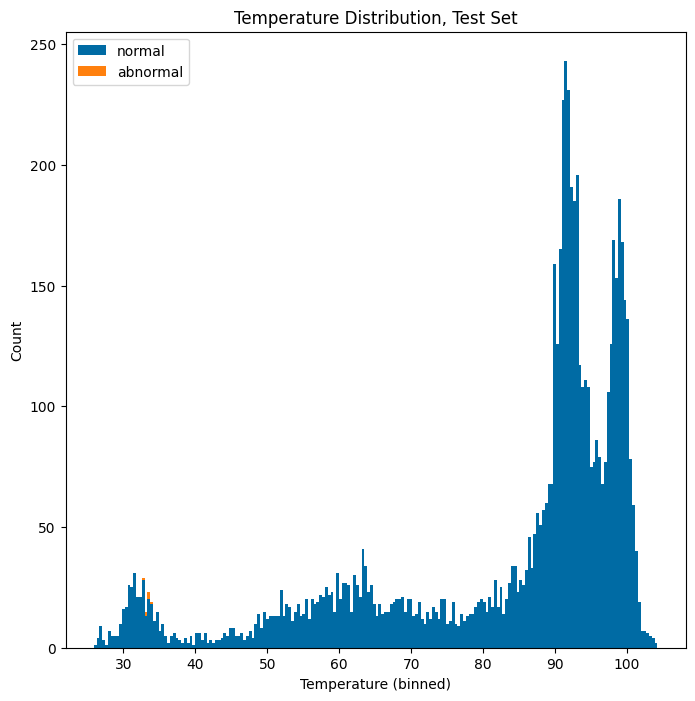

In [ ]:
anomalies_value = data_with_losses_unscaled.loc[data_with_losses_unscaled['anomaly'], ['loss','value']]
normals_value = data_with_losses_unscaled.loc[~data_with_losses_unscaled['anomaly'], ['loss','value']]
plt.figure(figsize=(8,8))
plt.hist([normals_value['value'], anomalies_value['value']], bins=200, stacked=True, label=['normal', 'abnormal'])
plt.title("Temperature Distribution, Test Set")
plt.xlabel("Temperature (binned)")
plt.ylabel("Count")
plt.legend();

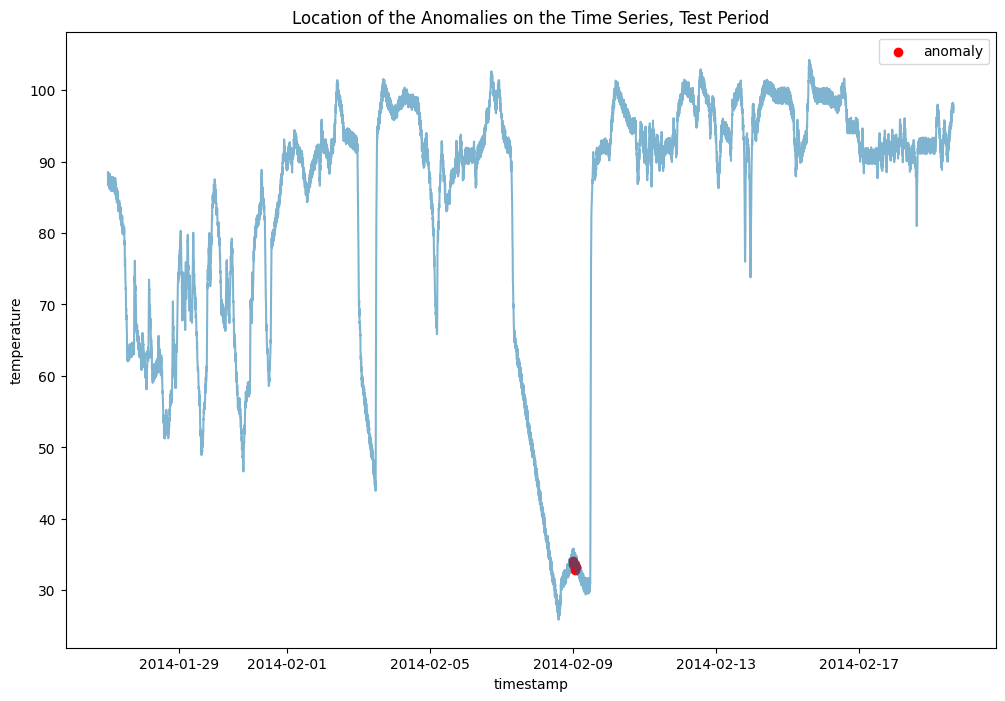

In [ ]:
anomalies_ts = data_with_losses_unscaled.loc[data_with_losses_unscaled['anomaly'], ('timestamp', 'value')]
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(data_with_losses_unscaled['timestamp'], data_with_losses_unscaled['value'], alpha=.5)
ax.scatter(anomalies_ts['timestamp'], anomalies_ts['value'], color='red', label='anomaly')
plt.legend()
plt.xlabel("timestamp")
plt.ylabel("temperature")
plt.title("Location of the Anomalies on the Time Series, Test Period");

It's a little hard to tell on this figure, but the instances flagged as abnormal (stacked over the normal ones near the left-hand tail) are not at the extreme end of the temperature spectrum, as they would have been if we had used a more naive approach based only on the temperature. Let see these flagged examples on the original timeseries:


With a threshold at the 99.9th centile, our model correctly detects the anomaly present in the test period, albeit a bit late, and does not generate any false positives. The threshold that we defined can be adjusted to favour precision or recall and the optimal value could be determined by the area under the precision-recall curve. It would also be interesting to perform an ablation study to understand which of the engineered features are the most helpful.

I hope this notebook was informative and gave you some insight into VAEs and their usefulness in anomaly detection!

## References
\[1\] Doersch, C. (2016). Tutorial on variational autoencoders. arXiv preprint arXiv:1606.05908.  
\[2\] Ahmad, S., Lavin, A., Purdy, S., & Agha, Z. (2017). Unsupervised real-time anomaly detection for streaming data. Neurocomputing, 262, 134-147.